# CSE 252B: Computer Vision II, Winter 2019 – Assignment 5
### Instructor: Ben Ochoa
### Due: Wednesday, March 20, 2019, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* Your code and results should remain inline in the pdf (Do not move your code to an appendix).
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Math): Point on Line Closest to the Origin (5 points)
  Given a line $\boldsymbol{l} = (a, b, c)^\top$, show that the point on
  $\boldsymbol{l}$ that is closest to the origin is the point $\boldsymbol{x} =
  (-ac, -bc, a^2+b^2)^\top$ (Hint: this calculation is needed in the
  two-view optimal triangulation method used below).

Given a line $\boldsymbol{l} = (a, b, c)^\top$, a homogeneous 2D point on the line $\boldsymbol{X} = (x, y, 1)^\top$ satisfy the equation $\boldsymbol{{l}^\top x} = 0$.
We can then expand the equation $\boldsymbol{{l}^\top x} = 0$ as below: 

$\boldsymbol{{l}^\top x} = (a, b, c)^\top \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}\\
= ax + by + c \\
= 0 $ 

Thus, we can then solve $y = \frac {-(ax + c)}{b} $ and rewrite the point on the line $\boldsymbol{x}$ as $(x, \frac {-(ax + c)}{b}, 1)^\top$. Since the vector pointing from the closest point to the origin on the line should have the same slope as the line, we can then solve $x$ as below:

$\frac{(\frac{-(ax + c)}{b} - 0)}{(x - 0)} = \frac{b}{a} \\
bx = \frac{-a^2x - ac}{b} \\
x = \frac{-ac}{a^2 + b^2}$

with $x$ we can also solve $y$ as $\frac{-bc}{a^2 + b^2}$ and the homogenous point $\boldsymbol{x} = (\frac{-ac}{a^2 + b^2}, \frac{-bc}{a^2 + b^2}, 1)^\top$. Since $X$ is a homogeneous point, we can then multipy each element by $a^2 + b^2$ and obtain the final answer $\boldsymbol{x} =
  (-ac, -bc, a^2+b^2)^\top$.

## Problem 2 (Programming): Feature Detection (20 points)
Download input data from the course website. The file IMG_5030.JPG
contains image 1 and the file IMG_5031.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 1350–1400 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features, where the detected features are indicated by a square window (the size of the detection window) about the features

In [1]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def AddandAverage(i, j, width, I):
    return np.average(I[i - width : i + width + 1, j - width : j + width + 1])

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve2d as conv2d


def ImageGradient(I, w, t):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    #
    # outputs:
    # N is the 2x2xmxn gradient matrix
    # b in the 2x1xmxn vector used in the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    
    
    m,n = I.shape[:2]
    N = np.zeros((2,2,m,n))
    b = np.zeros((2,1,m,n))
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
        
    ####Compute Gradient
    Ix2, Iy2, IxIy = np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape)
    Ixb2, Iyb2 = np.zeros(I.shape), np.zeros(I.shape)
    gradFilt = np.array([-1, 8, 0, -8, 1]) / 12
    
    
    for i in range(2, I.shape[1] - 2): ##x
        for j in range(2, I.shape[0] - 2): ##y
            ix = np.dot(I[j, i - 2 : i + 3], gradFilt)
            iy = np.dot(I[j - 2 : j + 3, i], gradFilt.T)
            Ix2[j, i], Iy2[j, i], IxIy[j, i] = ix **2, iy **2, ix * iy
            Ixb2[j, i], Iyb2[j, i] = Ix2[j, i] * i + IxIy[j, i] * j, Iy2[j, i] * j + IxIy[j, i] * i
    
    width = (w - 1) // 2
    for i in range(width, m - width):
        for j in range(width, n - width):
            ix2, iy2, ixiy = AddandAverage(i, j, width, Ix2), AddandAverage(i, j, width, Iy2), AddandAverage(i, j, width, IxIy)
            ixb2, iyb2 = AddandAverage(i, j, width, Ixb2), AddandAverage(i, j, width, Iyb2)
            N[:, :, i, j] = np.matrix([[ix2, ixiy], [ixiy, iy2]])
            b[:, :, i, j] = np.matrix([[ixb2], [iyb2]])
            w, v = np.linalg.eig(N[:, :, i, j])
            J0[i, j] = np.min(w)
            if J0[i, j] > t:
                J1[i, j] = J0[i, j]

    return N, b, J0, J1
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w
    # For any window in J, the result should only contain 1 nonzero value
    # In the case of multiple identical maxima in the same window,
    # the tie may be broken arbitrarily
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
       
    J2 = J.copy()
    Jmax = np.zeros(J2.shape)
    width = (w_nms - 1) // 2
    for i in range(width, J.shape[0]):
        for j in range(width, J.shape[1]):
            Jmax[i, j] = np.max(J2[i - width : i + width + 1, j - width : j + width + 1])
    
    for i in range(width, J.shape[0]):
        for j in range(width, J.shape[1]):
            if J[i, j] < Jmax[i, j]:
                J2[i, j] = 0
            else:
                J2[i, j] = Jmax[i, j]
    
    return J2
  
def ForstnerCornerDetector(J, N, b):
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # J is the NMS image
    # N is the 2x2xmxn gradient matrix
    # b is the 2x1xmxn vector computed in the image_gradient function
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC list of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    
    pts = np.zeros((2, 1))
    C = 0
    for i in range(0, J.shape[0]):
        for j in range(0, J.shape[1]):
            if J[i, j] != 0:
                C += 1
                pts = np.hstack((pts, np.dot(np.linalg.inv(N[:, :, i, j]), b[:, :, i, j])))
                
    return C, pts

# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    N, b, J0, J1 = ImageGradient(I, w, t)
    J2 = NMS(J1, w_nms)
    C, pts = ForstnerCornerDetector(J2, N, b)
    return C, pts, J0, J1, J2


took 186.828683 secs


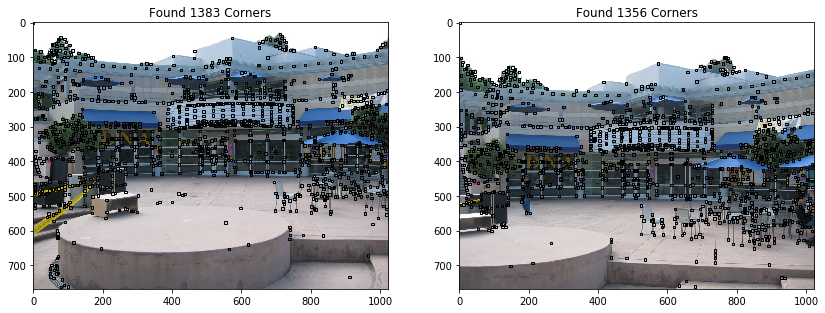

In [3]:
from PIL import Image
import time

# input images
I1 = np.array(Image.open('IMG_5030.JPG'), dtype='float')/255.
I2 = np.array(Image.open('IMG_5031.JPG'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.00105
w_nms = 7

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(rgb2gray(I1), w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(rgb2gray(I2), w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('Found %d Corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('Found %d Corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.00105
* w_nms = 7
* C1 = 1383
* C2 = 1356

## Problem 3 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 300 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features are indicated by a square window (the size of the matching window) about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

In [4]:
import numpy.ma as ma
from math import sqrt

def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    scores = np.zeros((pts1.shape[1], pts2.shape[1])) 
    R = (w - 1) // 2
    
    pts1 = pts1.astype(int)
    pts2 = pts2.astype(int)
    
    
    for i in range(0, scores.shape[0]):
        if pts1[1, i] < R or pts1[1, i] >= I1.shape[0] - R or pts1[0, i] < R or pts1[0, i] >= I1.shape[1] - R:
            continue
        for j in range(0, scores.shape[1]):
            if pts2[1, j] < R or pts2[1, j] >= I2.shape[0] - R or pts2[0, j] < R or pts2[0, j] >= I2.shape[1] - R:
                continue
            if np.abs(pts1[1, i] - pts2[1, j]) > p or np.abs(pts1[0, i] - pts2[0, j]) > p:
                scores[i, j] = -1
                continue
            w1 = I1[pts1[1, i] - R : pts1[1, i] + R + 1, pts1[0, i] - R : pts1[0, i] + R + 1]
            w2 = I2[pts2[1, j] - R : pts2[1, j] + R + 1, pts2[0, j] - R : pts2[0, j] + R + 1]
            mean1, mean2 = np.mean(w1), np.mean(w2)   
            denom1, denom2 = np.sum((w1 - mean1) ** 2), np.sum((w2 - mean2) ** 2)
            matching_score = np.sum((w1 - mean1) * (w2 - mean2))
            scores[i, j] = (matching_score / sqrt(denom1 * denom2))

    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    

    mask = ma.array(scores)
    inds = np.zeros((2, 1))
    
    while np.max(mask) > t:
        maximum = np.max(mask)
        index = np.unravel_index(np.argmax(mask), scores.shape)
        mask[index] = ma.masked
        nextbest = max(mask[index[0],:].max(), mask[:, index[1]].max())
        if (1 - maximum) < ((1 - nextbest) * d):
            inds = np.hstack((inds, np.array([[index[0]], [index[1]]])))
        mask[index[0], :] = ma.masked
        mask[:, index[1]] = ma.masked
    
    inds = inds[:, 1:]
    
    return inds.astype(int)

def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p=0):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d) 
    return inds


took 37.373873 secs


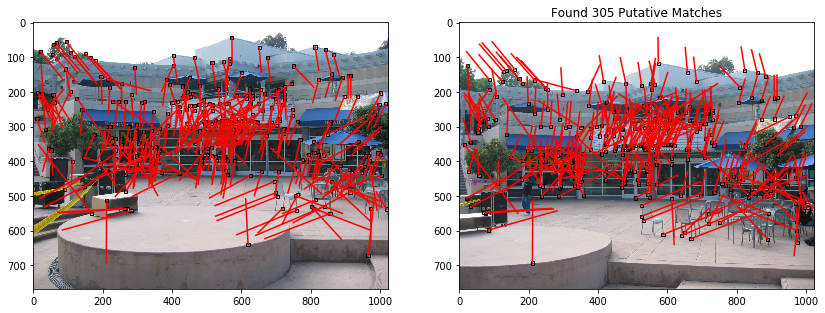

unique points in image 1: 305
unique points in image 2: 305


In [5]:
# parameters to tune
w = 9
t = 0.78
d = 0.75
p = 200

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(rgb2gray(I1), rgb2gray(I2), pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:]]
match2 = pts2[:,inds[1,:]]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('Found %d Putative Matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 9
* t = 0.78
* d = 0.75
* p = 200
* num_matches = 305

## Problem 4 (Programming): Outlier Rejection (20 points)
  
  The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 7-point algorithm (as described in
lecture) to estimate the fundamental matrix, resulting in 1 or 3 solutions. Calculate 
the (squared) Sampson error as a first order approximation to the geometric error.

Hint: this problem has codimension 1

Also: fix a random seed in your MSAC. If I cannot reproduce your results, you will lose points.

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 * random seed
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

In [6]:
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))


def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    dim = pts.shape[0]
    mean = np.mean(pts, axis = 1).reshape((dim, 1))
    var = np.var(pts, axis = 1)
    totalVar = np.sum(var)
    s = np.sqrt(dim / totalVar)
    
    #construct T
    T = np.hstack((np.identity(dim) * s, mean * s * -1))
    T = np.vstack((T, np.zeros(dim + 1)))
    T[-1, -1] = 1
    
    pts = Homogenize(pts)
    pts = np.dot(T, pts)
    
    return pts, T

In [7]:
from scipy.stats import chi2
from sympy import *

def compute_cost(error, tol):
    consensus_cost = 0
    inlier_count = 0
    for i in range(error.shape[0]):
        if error[i] > tol:
            consensus_cost += tol
        else:
            consensus_cost += error[i]
            inlier_count += 1
    return consensus_cost, inlier_count

def calculate_tolerance(alpha):
    lam, var, cod = alpha, 1, 1
    t = chi2.ppf(lam, cod) * var
    return t

def sampsonError(x, x_p, F):
    error = []
    
    for i in range(0, x.shape[1]):
        xi, xi_p = x[:, i].reshape((-1, 1)), x_p[:, i].reshape((-1, 1))
        nom = (xi_p.T @ F @ xi)** 2
        denom = (xi_p.T @ F[:, 0])** 2 + (xi_p.T @ F[:, 1])** 2 + (F[0, :] @ xi)** 2 + (F[1, :] @ xi)** 2
        error.append((nom / denom).flatten())
    return np.asarray(error).flatten()

def sevenPointAlgorithm(x, x_p):
    if x.shape[1] != 7:
        print("-- There are not exactly 7 points! --")
    
    #### construct A
    A = np.kron(x_p[:, 0].T, x[:, 0].T).reshape((1, -1))
    for i in range(1, x.shape[1]):
        A = np.vstack((A, np.kron(x_p[:, i].T, x[:, i].T).reshape(1, -1)))
    
    #### find a, b, and F1, F2 should be right null space
    u, s, vt = np.linalg.svd(A)
    a, b = vt[-1, :], vt[-2, :]
    F1, F2 = np.reshape(a, (3, 3)), np.reshape(b, (3, 3))
    
    #### solve for lambda
    alpha = Symbol("alhpa")
    F1_tmp, F2_tmp = Matrix(F1), Matrix(F2)
    alpha_result = solve((alpha * F1_tmp + F2_tmp).det(), alpha, cubics=False)
    alpha_result = np.fromiter(alpha_result, dtype=complex)
    
    #### construct F
    F = []
    for i in range(alpha_result.shape[0]):
        if np.isreal(alpha_result[i]):
            alpha = np.real(alpha_result[i])
            F.append(alpha * F1 + F2)
                      
    return F

took 13.041046 secs
23 iterations
inlier count:  165
inliers:  [3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 25, 26, 31, 33, 35, 36, 40, 42, 44, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 82, 83, 84, 86, 89, 90, 92, 95, 97, 98, 100, 101, 103, 104, 108, 109, 113, 114, 115, 116, 118, 119, 121, 122, 125, 128, 132, 134, 136, 139, 141, 142, 143, 144, 146, 149, 152, 153, 155, 156, 157, 161, 162, 163, 165, 167, 168, 169, 170, 171, 172, 173, 175, 176, 178, 181, 182, 183, 184, 186, 188, 189, 190, 191, 194, 196, 197, 198, 199, 200, 201, 203, 205, 208, 209, 211, 219, 220, 221, 222, 224, 225, 226, 231, 232, 233, 234, 237, 238, 241, 243, 248, 249, 250, 254, 255, 265, 267, 269, 271, 272, 274, 275, 276, 277, 279, 280, 283, 286, 288, 290, 293, 294, 295, 297, 302, 303]
MSAC Cost = 621.418336674
F_MSAC = 
[[ 4.91879183e-09  8.92349076e-07 -3.17402293e-04]
 [-7.49631788e-07  5.36116344e-07 -3.03564572e-03]
 [ 3.30151118e-04  2.50459604e-03  

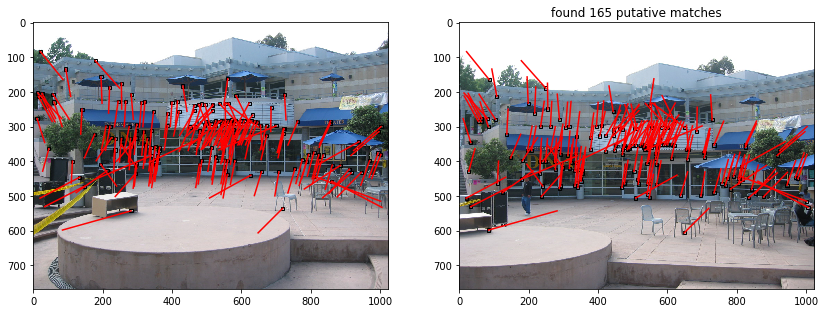

In [8]:
import pdb
def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - fundamental matrix F
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set    

    pts1_homo, pts2_homo = Homogenize(pts1), Homogenize(pts2)
    
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,3))
    inliers = []
    total_point_num = pts1.shape[1]
    
    while trials < max_trials and consensus_min_cost > thresh:
        idx = np.random.choice(pts1.shape[1], 7, replace = False)
        pts1_sampled, pts2_sampled = pts1[:, idx], pts2[:, idx]
        pts1_norm_sampled, T_1 = Normalize(pts1_sampled)
        pts2_norm_sampled, T_2 = Normalize(pts2_sampled)
        F_cand = sevenPointAlgorithm(pts1_norm_sampled, pts2_norm_sampled)
        
        ###### denormalize F
        for i in range(len(F_cand)):
            F_cand[i] = T_2.T @ F_cand[i] @ T_1
        
        ###### compute error for each set of points
        error = []
        for f in F_cand:
            error.append(sampsonError(pts1_homo, pts2_homo, f))
        
        consensus_cost = np.inf
        for i in range(len(error)):
            cost, count = compute_cost(error[i], tol)
            if cost < consensus_cost:
                consensus_cost = cost
                inlier_count = count
                F = F_cand[i]
        
        ###### determine if this is the model we want
        if consensus_cost < consensus_min_cost:
            consensus_min_cost = consensus_cost
            consensus_min_cost_model = F
            ###### adaptive max trials
            w = inlier_count / total_point_num
            max_trials = np.log(1 - p) / np.log(1 - w ** 7)
        
        trials += 1
        #print("max_trials: ", max_trials)
        #print("max_cost: ", consensus_cost)
        
    #### find set of inliers
    error = sampsonError(pts1_homo, pts2_homo, consensus_min_cost_model)
    for i in range(total_point_num):
        if error[i] <= tol:
            inliers.append(i)
            
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh = 650
alpha = 0.95
tol = calculate_tolerance(alpha)
p = 0.99
#np.random.seed(8888) ## set random seed
np.random.seed(4444)
tic=time.time()

cost_MSAC, F_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
x1 = match1[:,inliers]
x2 = match2[:,inliers]
outliers = np.setdiff1d(np.arange(match1.shape[1]),inliers)

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost = %.9f'%cost_MSAC)
print('F_MSAC = ')
print(F_MSAC)

# display the figures
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)

plt.title('found %d putative matches'%x1.shape[1])
for i in range(x1.shape[1]):
    x_1,y_1 = x1[:,i]
    x_2,y_2 = x2[:,i]
    ax1.plot([x_1, x_2],[y_1, y_2],'-r')
    ax1.add_patch(patches.Rectangle((x_1-w/2,y_1-w/2),w,w, fill=False))
    ax2.plot([x_2, x_1],[y_2, y_1],'-r')
    ax2.add_patch(patches.Rectangle((x_2-w/2,y_2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* random seed = 4444
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 3.841458820694124
* threshold = 650
* num_inliers = 165
* num_attempts = 23
* consensus_min_cost = 621.418336674

## Problem 5 (Programming): Linear Estimation of the Fundamental Matrix (15 points)
  Estimate the fundamental matrix $\boldsymbol{F}_\text{DLT}$ from the
  resulting set of inlier correspondences using the direct linear
  transformation (DLT) algorithm (with data normalization).  Include
  the numerical values of the resulting $\boldsymbol{F}_\text{DLT}$, scaled
  such that $||\boldsymbol{F}_\text{DLT}||_\text{Fro} = 1$

In [9]:
def SampsonCorrection(x, x_p, F):
    x_homo, x_p_homo = x, x_p
    x = Dehomogenize(x)
    x_p = Dehomogenize(x_p)
    
    f11, f12, f13, f21, f22, f23, f31, f32, f33 = \
        F[0, 0], F[0, 1], F[0, 2], F[1, 0], F[1, 1], F[1, 2], F[2, 0], F[2, 1], F[2, 2]
    
    for i in range(x_p.shape[1]):
        xi, yi = x[0, i], x[1, i]
        xi_p, yi_p = x_p[0, i], x_p[1, i]
        
        ## should be a scaler
        E = x_p_homo[:, i].T.reshape((1, -1)) @ F @ x_homo[:, i]
        
        ## J is (1 x 4)
        J = np.array([[xi_p * f11 + yi_p * f21 + f31, xi_p * f12 + yi_p * f22 + f32, \
                    xi * f11 + yi * f12 + f13, xi * f21 + yi * f22 + f33]])
        
        lam = np.linalg.inv(J @ J.T) * -E
        eps = J.T @ lam
        x_scene[:, i] = x_scene[:, i] + eps.reshape(-1)
        
    return x_scene[:2, :]

def leftNullofVector(X):
    X = X.reshape((X.shape[0], 1))
    e = np.zeros(X.shape)
    e[0, 0] = 1
    
    v = X + np.sign(X[0, 0]) * np.linalg.norm(X) * e
    Hv = np.identity(X.shape[0]) - 2 * (v @ v.T) / (v.T @ v)
    
    return Hv[1:, :]

In [10]:
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates    
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates   
    return x[:-1]/x[-1]

def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    F - the DLT estimate of the fundamental matrix  
        
    ##### data normalization
    if normalize:
        x1, T_1 = Normalize(x1)
        x2, T_2 = Normalize(x2)
    else:
        x1 = Homogenize(x1)
        x2 = Homogenize(x2)
    
    ##### construct A
    A = np.zeros((1, 9))    
    for col in range(0, x1.shape[1]):
        A = np.vstack((A, np.kron(x2[:, col].T, x1[:, col].T)))
    A = A[1:]
    
    ##### find F
    u, s, vt = np.linalg.svd(A)
    F = vt[-1, :]
    F = np.reshape(F, (3, 3))
    
    ##### enforce F singularity constraint
    u, s, vt = np.linalg.svd(F)
    s[-1] = 0
    F = u @ np.diag(s) @ vt
        
    ##### data denormalization
    if normalize:
        F = T_2.T @ F @ T_1
    F = F / np.linalg.norm(F)
    
    
    return F


# compute the linear estimate with data normalization
print ('DLT with Data Normalization')
time_start=time.time()
F_DLT = DLT(x1, x2, normalize=True)
time_total=time.time()-time_start

# display the resulting F_DLT, scaled with its frobenius norm
print('F_DLT =')
print(F_DLT)

DLT with Data Normalization
F_DLT =
[[ 1.04820686e-08  2.07841557e-06 -7.48242626e-04]
 [-1.28928843e-06  9.78275947e-07 -1.04373841e-02]
 [ 5.96573319e-04  9.13805714e-03  9.99903316e-01]]


## Problem 6 (Programming): Nonlinear Estimation of the Fundamental Matrix (70 points) 
  Retrieve the camera projection matrices $\boldsymbol{P} = [\boldsymbol{I} \,|\,
  \boldsymbol{0}]$ and $\boldsymbol{P}' = [\boldsymbol{M} \,|\, \boldsymbol{v}]$, where $\boldsymbol{M}$
  is full rank, from $\boldsymbol{F}_\text{DLT}$.  Use the resulting camera
  projection matrix $\boldsymbol{P}'$ associated with the second image and
  the triangulated 3D points as an initial estimate to an iterative
  estimation method, specifically the sparse Levenberg-Marquardt
  algorithm, to determine the Maximum Likelihood estimate of the
  fundamental matrix $\boldsymbol{F} = [\boldsymbol{v}]_\times \boldsymbol{M}$ that
  minimizes the reprojection error.  The initial estimate of the 3D
  points must be determined using the two-view optimal triangulation
  method described in lecture (algorithm 12.1 in the Hartley \&
  Zisserman book, but use the ray-plane intersection method for the
  final step instead of the homogeneous method).  Additionally, you
  must parameterize the camera projection matrix $\boldsymbol{P}'$ associated
  with the second image and the homogeneous 3D scene points that are
  being adjusted using the parameterization of homogeneous vectors
  (see section A6.9.2 (page 624) of the textbook, and the corrections
  and errata).
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the fundamental matrix $\boldsymbol{F}_\text{LM}$, scaled
  such that $||\boldsymbol{F}_\text{LM}||_\text{Fro} = 1$.

In [11]:
def skew(w):
    w = w.reshape((3, -1))
    w_skew = np.matrix([[0, -w[2], w[1]],
                        [w[2], 0, -w[0]],
                        [-w[1], w[0], 0]])
    return w_skew

def parameterizeF(F):
    U, D, Vt = np.linalg.svd(F)
    s, t = D[0], D[1]
    W = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
    ZD_p = np.array([[0, -t, 0], [s, 0, 0], [0, 0, (s + t) / 2]])
    #Vt[-1] = -Vt[-1]
    S = U @ W @ U.T
    M = U @ ZD_p @ Vt
    e_p = np.array([S[2, 1], S[0, 2], S[1, 0]]).reshape((-1, 1))
    P_p = np.hstack((M, e_p))
    return P_p

def deparameterizeF(P_p):
    M, e_p = P_p[:, :3], P_p[:, 3]
    return skew(e_p) @ M

In [12]:
def findRightNullSpace(M):
    U, D, Vt = np.linalg.svd(M)
    return Vt[-1, :]

def formRotationMatrix(e):
    return np.array([[e[0], e[1], 0], [-e[1], e[0], 0], [0, 0, 1]])

def solve_t(a, b, c, d, f, f_p):
    t = Symbol("t")
    t_result = solveset(t * (((a * t + b) ** 2) + (f_p ** 2) * (c* t + d) ** 2) ** 2 \
                     - (a * d - b * c) * ((1 - (f ** 2) * (t ** 2)) ** 2) * (a * t + b) * (c * t + d), t)
    t_result = np.fromiter(t_result, dtype=complex)
    return t_result

In [13]:
def adjustPointCorrespondance4EachPoint(x, x_p, F):
    
    x = x.reshape((-1, 1))
    x_p = x_p.reshape((-1, 1))
    
    ##### step1: form Fs
    x, y, w = x[0, 0], x[1, 0], x[2, 0]
    x_p, y_p, w_p = x_p[0, 0], x_p[1, 0], x_p[2, 0]
    #print("xyw", x, y, w)
    
    T = np.array([[w, 0, -x], [0, w, -y], [0, 0, w]])
    T_p = np.array([[w_p, 0, -x_p], [0, w_p, -y_p], [0, 0, w_p]])
    Fs = np.linalg.inv(T_p.T) @ F @ np.linalg.inv(T)
    
    ##### step2: calculate epipol
    e_p = findRightNullSpace(Fs.T)
    e = findRightNullSpace(Fs)
    e = np.sqrt(1 / (e[0] ** 2 + e[1] ** 2)) * e
    e_p = np.sqrt(1 / (e_p[0] ** 2 + e_p[1] ** 2)) * e_p

    ##### step3: form rotation matrix and determine a, b, c, d, f, f_p
    R = formRotationMatrix(e)
    R_p = formRotationMatrix(e_p)
    Fs = R_p @ Fs @ R.T
    a, b, c, d = Fs[1, 1], Fs[1, 2], Fs[2, 1], Fs[2, 2]
    f, f_p = e[2], e_p[2]
    
    ##### step4: form polynomial g(t) and solve for t (6 roots)
    t_list = solve_t(a, b, c, d, f, f_p)
    
    ##### step5: evaluate the cost function (at t = inf and all real part of each root)
    ## get real part of root
    t_real = []
    for i in range(t_list.shape[0]):
        t_real.append(np.real(t_list[i])) 
        
    ## calculate and find smallest cost
    ## use t = inf to be the mincost 
    mint, mincost = np.inf, (1 / (f **2)) + ((c ** 2) / ((a ** 2) + (f_p ** 2) * (c ** 2)))
    for t in t_real:
        term1 = (t ** 2) / (1 + (f ** 2) * (t ** 2))
        term2 = ((c * t + d) ** 2) / (((a * t + b) ** 2) + (f_p ** 2) * ((c * t + d) ** 2))
        cost = term1 + term2
        if cost < mincost:
            mint = t
            mincost = cost
    t = mint
    
    ##### step6: determin x_hat and x_hat_p with l and l_p (solve point on line closest to center)
    if t != np.inf:
        l = np.array([t * f, 1, -t]).reshape((-1, 1))
        l_p = np.array([-f_p * (c * t + d), a * t + b, c * t + d]).reshape((-1, 1)) ##### check!!!!! e or a??
    else:
        l = np.array([f, 0, -1]).reshape((-1, 1))
        l_p = np.array([-f_p * c, a, c]).reshape((-1, 1))  ##### check!!!!! e or a??
    
    x_h = np.array([-l[0] * l[2], -l[1] * l[2], l[0] ** 2 + l[1] ** 2]).reshape((-1, 1))
    x_p_h = np.array([-l_p[0] * l_p[2], -l_p[1] * l_p[2], l_p[0] ** 2 + l_p[1] ** 2]).reshape((-1, 1))

    ##### step7: corrected points mapped back to original coordinates
    x_h = np.linalg.inv(T) @ R.T @ x_h
    x_p_h = np.linalg.inv(T_p) @ R_p.T @ x_p_h

    return x_h, x_p_h

def find3DPoint4EachPoint(x, x_p, F, P_p):

    ##### step1: map point x to line l_p using F, map l_orth
    l_p = F @ x
    a_p, b_p, c_p = l_p[0], l_p[1], l_p[2]
    x_p, y_p, w_p = x_p[0], x_p[1], x_p[2]
    l_orth = (-b_p * w_p, a_p * w_p, b_p * x_p - a_p * y_p) #### check
    
    #### step2: backproject l_orth to plane pi
    pi = P_p.T @ l_orth 
    a, b, c, d = pi[0], pi[1], pi[2], pi[3]
    
    #### step2: find 2 points X1 = c and X2 = X    ### check use P or P_p
    x, y, w = x[0], x[1], x[2]
    X1 = np.array([0, 0, 0, 1]).reshape((-1, 1))
    X2 = np.array([x, y, w, 0]).reshape((-1, 1))
    
    #### X_pi
    X_pi = np.array([d * x, d * y, d * w, -(a * x + b * y + c * w)]).reshape((-1, 1))
    #pdb.set_trace()
    return X_pi    

In [14]:
def adjustPointCorrespondance(x, x_p, F):
    x_h, x_p_h = np.zeros((3, 1)), np.zeros((3, 1))
    for i in range(x.shape[1]):
        #print("point", i)
        xi_h, xi_p_h = adjustPointCorrespondance4EachPoint(x[:, i], x_p[:, i], F)
        x_h = np.hstack((x_h, xi_h))
        x_p_h = np.hstack((x_p_h, xi_p_h))
    return x_h[:, 1:], x_p_h[:, 1:]

def find3DPoint(x, x_p, F, P_p):
    X_pi = np.zeros((4, 1))
    for i in range(x.shape[1]):
        X_pi_i = find3DPoint4EachPoint(x[:, i], x_p[:, i], F, P_p)
        X_pi = np.hstack((X_pi, X_pi_i))
    return X_pi[:, 1:]
        
def findOptimal3Dpoint(x, x_p, F, P_p):
    x_h, x_p_h = adjustPointCorrespondance(x, x_p, F)
    X_pi = find3DPoint(x_h, x_p_h, F, P_p)
    
    return X_pi      

In [15]:
def Parameterize(P, isP = True):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them
    # in this case it is just P, but in future assignments it will
    # be more useful
    if isP:
        return ParameterizeHomog(P.reshape(-1,1))
    else:
        result = np.zeros((P.shape[0] - 1, 1))
        for i in range(P.shape[1]):
            result = np.hstack((result, ParameterizeHomog(P[:, i]).reshape(-1, 1)))
        return result[:, 1:]


def Deparameterize(p, isP = True):
    # Deparameterize all optimization variables
    if isP:
        return DeParameterizeHomog(p).reshape((3, 4))
    else:
        result = np.zeros((p.shape[0] + 1, 1))
        for i in range(p.shape[1]):
            result = np.hstack((result, DeParameterizeHomog(p[:, i]).reshape(-1, 1)))
        return result[:, 1:]
    
def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization
    v = V / np.linalg.norm(V) 
    a, b = v[0], v[1:]
    v_hat = (2 / Sinc(np.arccos(a))) * b

    norm = np.linalg.norm(v_hat)
    if norm > np.pi:
        v_hat *= 1 - ((2 * np.pi) / norm) * np.ceil((norm - np.pi) /(2 * np.pi))
    return v_hat

def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    norm = np.linalg.norm(v)
    v_bar = np.zeros((v.shape[0] + 1, 1))
    v_bar = np.array([np.cos(norm / 2)]).reshape((-1, 1))
    v_bar = np.vstack((v_bar, ((Sinc(norm / 2) / 2)* v).reshape((-1, 1))))
    v_bar /= np.linalg.norm(v_bar)
    return v_bar

def ConstructParamVect(x_scene, f):
    tmp_x = x_scene.reshape((1, -1), order='F')
    return np.hstack((f.T, tmp_x))

def ComputeCost(E, E_p, invcov, invcov_p):
    cost = 0
    for i in range(E.shape[1]):
        cost += E[:, i].reshape((-1, 1)).T @ invcov @ E[:, i].reshape((-1, 1)) + E_p[:, i].reshape((-1, 1)).T @ invcov_p @ E_p[:, i].reshape((-1, 1))
    return cost

In [16]:
def ComputeAB(P, P_p, x_scene):
    A_p, B, B_p = [], [], []
    x_hat = Dehomogenize(P @ x_scene)      ## [I|0] @ x_scene
    x_hat_p = Dehomogenize(P_p @ x_scene)  ## P' @ x_scene
    for i in range(x_scene.shape[1]):
        A_p.append(ComputeA_p(x_scene[:, i], x_hat_p[:, i], P_p))
        B.append(ComputeB(x_scene[:, i], x_hat[:, i], P))
        B_p.append(ComputeB(x_scene[:, i], x_hat_p[:, i], P_p))
    return A_p, B, B_p  

def ComputeA_p(x_scene, x_hat_p, P_p):
    x_scene = x_scene.reshape((-1, 1))
    w_p = P_p[2, :] @ x_scene
    term1 = dxhat_dpbar(x_scene, x_hat_p, w_p)
    term2 = dpbar_dp(P_p)
    return dxhat_dpbar(x_scene, x_hat_p, w_p) @ dpbar_dp(P_p)

def ComputeB(x_scene, x_hat, P):
    x_scene = x_scene.reshape((-1, 1))
    w_p = P[2, :] @ x_scene
    term1 = dxhat_dxscene(x_hat, P, w_p)
    term2 = dpbar_dp(x_scene, False)
    return dxhat_dxscene(x_hat, P, w_p) @ dpbar_dp(x_scene, False)

def dxhat_dpbar(x_scene, x_hat_p, w_p):
    zero = np.zeros((4, 1))
    row1 = np.hstack((x_scene.T, zero.T, -x_hat_p[0] * x_scene.T))
    row2 = np.hstack((zero.T, x_scene.T, -x_hat_p[1] * x_scene.T))
    
    return (1 / w_p) * np.vstack((row1, row2))

def dxhat_dxscene(x_hat, P, w_p):
    array = np.vstack((P[0, :] - x_hat[0] * P[2, :], P[1, :] - x_hat[1] * P[2, :]))
    return (1 / w_p) * array

def dpbar_dp(P, isP = True):
    p = Parameterize(P, isP)
    
    norm = np.linalg.norm(p)
    p_bar = P.reshape(-1, 1)

    a, b = p_bar[0], p_bar[1:]
    I = np.identity(b.shape[0])

    if norm == 0:
        da = np.zeros(b.shape.T)
        db = 0.5 * I
    else:
        da = -0.5 * b.T
        db = Sinc(norm / 2) / 2 * I + (1 / (4 * norm)) * dSinc(norm / 2) * p @ p.T
    
    dpbar_dp = np.vstack((da, db))
    return dpbar_dp
    

def ComputeUVW(A_p, B, B_p, invcov, invcov_p):
    U_p = np.zeros((11, 11))
    V, W_p = [], []
    for i in range(len(A_p)):
        U_p += A_p[i].T @ invcov_p @ A_p[i]
        V.append(B[i].T @ invcov @ B[i] + B_p[i].T @ invcov_p @ B_p[i])
        W_p.append(A_p[i].T @ invcov_p @ B_p[i]) ####### check

    return U_p, V, W_p

def ComputeEaEb(A_p, B, B_p, invcov, invcov_p, E, E_p):
    Ea_p = np.zeros((11, 1))
    Eb = np.zeros((3, 1))
    for i in range(E.shape[1]):
        Ea_p += A_p[i].T @ invcov_p @ E_p[:, i].reshape((-1, 1))   ######## check
        Eb = np.hstack((Eb, B[i].T @ invcov @ E[:, i].reshape((-1, 1))  + B_p[i].T @ invcov_p @ E_p[:, i].reshape((-1, 1)) ))
    return Ea_p, Eb[:, 1:]

def ComputeUpdate(U_p, V, W_p, lam, Ea_p, Eb):
    U_p_star = U_p + lam * np.identity(11)
    s_minus = np.zeros((11, 11))
    e_minus = np.zeros((11, 1))
    
    for i in range(len(W_p)):
        v_star_inv = np.linalg.inv(V[i] + lam * np.identity(3))
        s_minus += W_p[i] @ v_star_inv @ W_p[i].T
        e_minus += W_p[i] @ v_star_inv @ Eb[:, i].reshape((-1, 1)) #### check
    
    S_p = U_p_star - s_minus
    e_p = Ea_p - e_minus
    
    eps_a_p = np.linalg.inv(S_p) @ e_p
    eps_b = np.zeros((3, 1))
    
    for i in range(len(V)):
        v_star_inv = np.linalg.inv(V[i] + lam * np.identity(3))
        eps_b = np.hstack((eps_b, v_star_inv @ (Eb[:, i].reshape((-1, 1)) - W_p[i].T @ eps_a_p)))
    update = np.hstack((eps_a_p.T, eps_b[:, 1:].reshape((1, -1), order='F')))
    return update

def Sinc(x):
    # Returns a scalar valued sinc value
    if x == 0:
        return 1
    else:
        return (np.sin(x) / x)

def dSinc(x):
    if x == 0:
        return 0
    else:
        return np.cos(x) / x - np.sin(x) / np.square(x)
        

In [17]:
from scipy.linalg import block_diag

def LM(F, x1, x2, max_iters, lam):
    # Input:
    #    F - DLT estimate of the fundamental matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    F - Final fundamental matrix obtained after convergence
    
   
    ### data normalize point correspondances + data normalize 2D prospective transformation
    x1, T = Normalize(x1)
    x2, T_p = Normalize(x2)
    
    inhomo_x1 = Dehomogenize(x1)
    inhomo_x2 = Dehomogenize(x2)
    
    F = np.linalg.inv(T_p.T) @ F @ np.linalg.inv(T)
    invcov = np.linalg.inv(np.identity(2) * np.square(T[0, 0]))
    invcov_p = np.linalg.inv(np.identity(2) * np.square(T_p[0, 0]))
    
    #### get initial projection transformation
    P_p = parameterizeF(F)
    
    #### get initial scene points 
    x_scene = findOptimal3Dpoint(x1, x2, F, P_p)
    
    #### parameterize and construct the parameter vector
    x_scene_par = Parameterize(x_scene, False)
    x_scene = Deparameterize(x_scene_par, False)
    p_p = Parameterize(P_p)
    P_p = Deparameterize(p_p)
    par_vec = ConstructParamVect(x_scene_par, p_p).reshape((-1, 1)) ## (11 + 3 * n)
    
    #### compute initial cost
    P = np.hstack((np.eye(3), np.zeros((3, 1))))
    E = inhomo_x1 - Dehomogenize(P @ x_scene)
    E_p = inhomo_x2 - Dehomogenize(P_p @ x_scene)
    cost = ComputeCost(E, E_p, invcov, invcov_p)
    
    print ('iter %03d Cost %.20f'%(0, cost))
    for i in range(max_iters): 
        ##### Compute AB
        A_p, B, B_p = ComputeAB(P, P_p, x_scene)
        ##### Compute UVW
        U_p, V, W_p = ComputeUVW(A_p, B, B_p, invcov, invcov_p)
        ##### Compute EaEb
        Ea_p, Eb = ComputeEaEb(A_p, B, B_p, invcov, invcov_p, E, E_p)
        while(True):
            update = ComputeUpdate(U_p, V, W_p, lam, Ea_p, Eb)
            new_par_vec = par_vec + update.reshape((-1, 1))
            new_P_p = Deparameterize(new_par_vec[:11])
            new_x_scene = Deparameterize(new_par_vec[11:].reshape((3, -1), order = "F"), False)
            new_E = inhomo_x1 - Dehomogenize(P @ new_x_scene)
            new_E_p = inhomo_x2 - Dehomogenize(new_P_p @ new_x_scene)
            new_cost = ComputeCost(new_E, new_E_p, invcov, invcov_p)
            if new_cost < cost:
                thresh, cost = cost - new_cost, new_cost
                E, E_p, P_p, par_vec, x_scene = new_E, new_E_p, new_P_p, new_par_vec, new_x_scene
                lam = 0.1 * lam
                break
            elif new_cost > cost + 10 ** -7:
                lam = 10 * lam
            else:
                break
        
        print ('iter %03d Cost %.20f'%(i+1, cost))
        if thresh < 10 ** -7: 
            break
        thresh = 0
    
    #### deparmeterize to get F
    F = deparameterizeF(P_p)
                  
    #### data denormalization
    F = T_p.T @ F @ T
    F = F / np.linalg.norm(F)
      
    return F

# LM hyperparameters
lam = .001
max_iters = 10

# Run LM initialized by DLT estimate
print ('Sparse LM')
time_start=time.time()
F_LM = LM(F_DLT, x1, x2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

# display the resulting F_LM, scaled with its frobenius norm
print('F_LM =')
print(F_LM)

Sparse LM
iter 000 Cost 64.18141985303235230731
iter 001 Cost 54.85085917735705152154
iter 002 Cost 54.84335198684087231413
iter 003 Cost 54.84334642865421471924
iter 004 Cost 54.84334641584891301136
took 24.111489 secs
F_LM =
[[ 1.03199472e-08  2.23055309e-06 -7.95002450e-04]
 [-1.52500310e-06  1.00901932e-06 -1.05635254e-02]
 [ 6.88049071e-04  9.26940005e-03  9.99900687e-01]]


## Problem 7 (Programming): Point to Line Mapping (10 points)
  Qualitatively determine the accuracy of $\boldsymbol{F}_\text{LM}$ by
  mapping points in image 1 to epipolar lines in image 2.  Choose
  three distinct points $\boldsymbol{x}_{\{1,2,3\}}$ distributed in image 1
  that are not in the set of inlier correspondences and map them to
  epipolar lines $\boldsymbol{l'}_{\{1,2,3\}} = \boldsymbol{F}_\text{LM}
  \boldsymbol{x}_{\{1,2,3\}}$ in the second image under the fundamental
  matrix $\boldsymbol{F}_\text{LM}$.

  Include a figure containing the pair of images,
  where the three points in image 1 are indicated by a square (or
  circle) about the feature and the corresponding epipolar lines are
  drawn in image 2. Comment on the qualitative accuracy of the mapping. (Hint: each line 
  $\boldsymbol{l'}_i$ should pass through the point $\boldsymbol{x'}_i$ in image 2 that 
  corresponds to the point $\boldsymbol{x}_i$ in image 1).

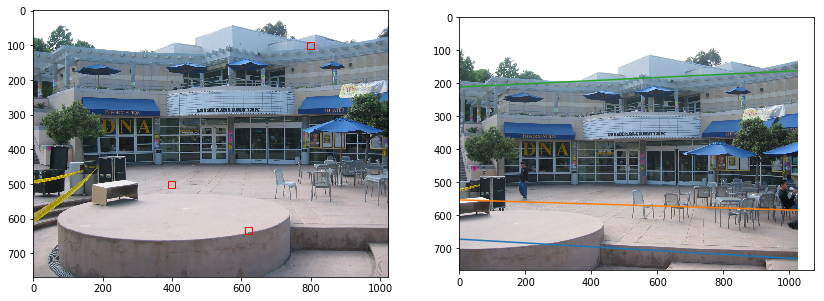

In [18]:
# create new matrices of points which contain only the matched features 
choose1 = np.array([[620, 400, 800], [635, 500, 100]])

l_p = F_LM @ Homogenize(choose1)

# # display the results
w = 20
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)

for i in range(choose1.shape[1]):
    a, b, c = l_p[0, i], l_p[1, i], l_p[2, i]
    x_1,y_1 = choose1[:,i]
    #x_2,y_2 = choose2[:,i]
    ax1.add_patch(patches.Rectangle((x_1-w/2,y_1-w/2),w,w, fill=False, color = 'r'))
    #ax2.add_patch(patches.Rectangle((x_2-w/2,y_2-w/2),w,w, fill=False, color = 'r'))
    start_y = -c / b
    end_y = -(I1.shape[1] * a + c) / b
    ax2.plot([0, I1.shape[1]], [start_y, end_y])

plt.show()


The results looks approximately accurate, the green line didn't exactly pass through the point, but the distance between the corresponding point and the line wasn't too big. As for the other two lines, the lines did pass the corresponding points.

## Problem 8 (Programming): Projective to Euclidean Reconstruction (15 points)

You are given a Matlab file containing points obtained from applying three-view geometry techniques (using the trifocal tensor) to obtain a projective reconstruction of points from a 3D scene. Also in the file are groundtruth control points. Compute the homography transformation using the DLT along with the projected 3D scene points and control points to upgrade the projective reconstruction to a Euclidean reconstruction. Render the scene, and comment on your results. What does the scene look like? (You may have to rotate the plot to get a better view.)


In [19]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

reconstruction = sio.loadmat('ereconstruction.mat')
X_projective = reconstruction['X_projective']
X_projective = X_projective.T
X_control = reconstruction['X_c']
X_control = X_control.T

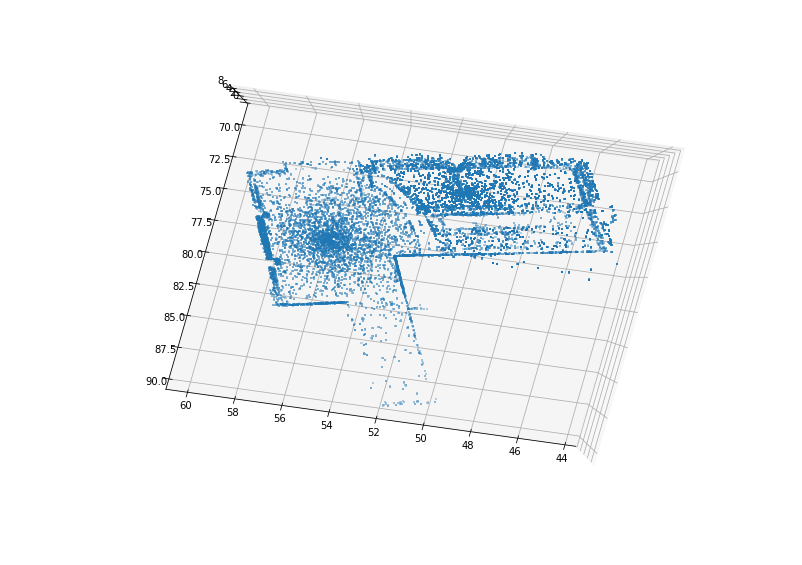

In [20]:
def ComputeHomography(Xp, Xc):
    
    Xp = Xp[:, :6]
    Xp = Dehomogenize(Xp)
    Xc = Dehomogenize(Xc)
    
    Xp, T = Normalize(Xp)
    Xc, T_2 = Normalize(Xc)
    
    A = np.zeros((1, 16))
    for col in range(0, Xc.shape[1]):
        xNull = leftNullofVector(Xc[:, col])
        A = np.vstack((A, np.kron(xNull, Xp[:, col].T)))
    
    A = A[1:]
    
    u, s, vt = np.linalg.svd(A)
    H = vt[-1, :]
    H = np.reshape(H, (4, 4))
    
    # data denormalize
    H = np.linalg.inv(T_2) @ H @ T
    H = H / np.linalg.norm(H)
    
    return H

H = ComputeHomography(X_projective, X_control)
X_euclidean = Dehomogenize(H @ X_projective)

Xe, Ye, Ze = X_euclidean[0,:], X_euclidean[1,:], X_euclidean[2,:] 
fig = plt.figure(figsize=(14, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(Xe, Ye, Ze, marker="+", s=5)

axis.view_init(90, 100)
plt.draw()
plt.show()

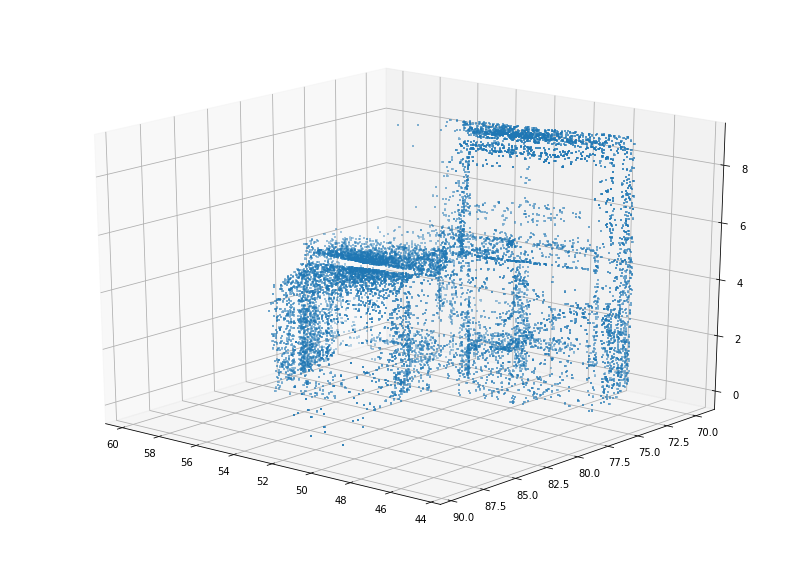

In [21]:
Xe, Ye, Ze = X_euclidean[0,:], X_euclidean[1,:], X_euclidean[2,:] 
fig = plt.figure(figsize=(14, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(Xe, Ye, Ze, marker="+", s=5)


axis.view_init(20, 130)
plt.draw()
plt.show()

We could see the contour of this structure thourgh the 3D  recontruction looking from the a bird eye view. I think this scene looks like an building, where the entrance in in the left of the above plot. 